# Final Project: Autostereograms

## CS445: Computational Photography

### Part I: Familiarization

In [1]:
#  Let's make some ASCII stereograms!
# Your eyes converge ( /\ ) or diverge ( \/ ) depending on the 3D depth of what they're looking at
# We can simulate looking at a single object at a distance X by looking at two identical objects at a distance less than X:


#     a  a  a  a  a  a  a  a  a  a  a  a  a 
#     b   b   b   b   b   b   b   b   b   b
#     c    c    c    c    c    c    c    c
#     d     d     d     d     d     d     d
#     c    c    c    c    c    c    c    c
#     b   b   b   b   b   b   b   b   b   b
#     a  a  a  a  a  a  a  a  a  a  a  a  a

#  There's a slight problem with the one above: the period of the 'a' is ambiguous.
#  when you look at the 'd' row, the 'a' row will appear to be the same, when it should really be closer
    
#     CloseCloseCloseCloseCloseCloseCloseClose
#     Far   Far   Far   Far   Far   Far   Far   
#     FurtherFurtherFurtherFurtherFurther
#     FurthestFurthestFurthestFurthestFurthest

In [1]:
# import libraries
import cv2
import numpy as np
from matplotlib.colors import LogNorm
from scipy import signal
%matplotlib inline  
import matplotlib.pyplot as plt
import matplotlib.animation
# define working directory
# datadir = "./" 

### Part II: Random Dot Autostereograms

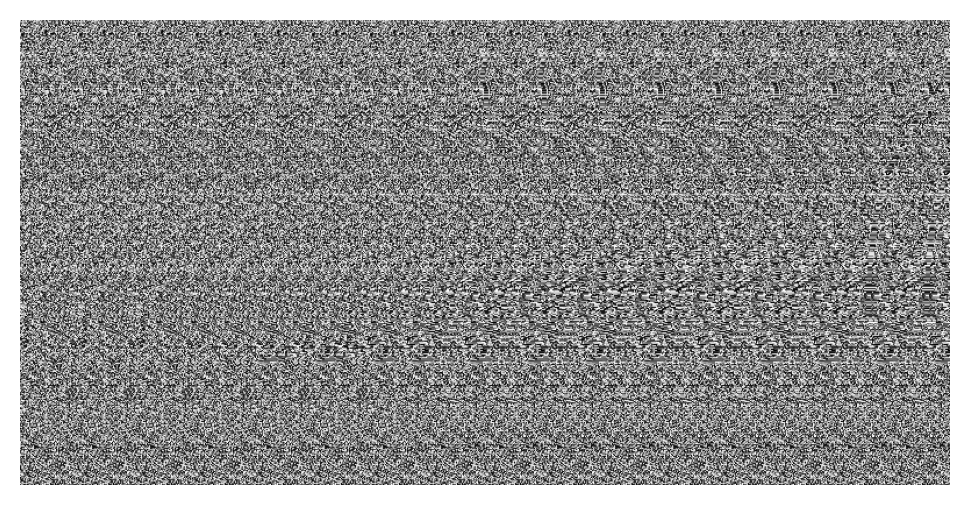

In [2]:
plt.rcParams['figure.dpi'] = 200

def make_stereogram(depth_img):

    intensity = 0.6 # intensity of 3D depth (0.0-1.0)
    patch_w = 50    # repeat-period corresponding to depth=0 in pixels
    out_size = (out_h, out_w) = (depth_img.shape[0], depth_img.shape[1]+patch_w)
    out = np.zeros(out_size).astype('double')

    for r, row in enumerate(out):
        # start with random array for row
        seed = np.random.random(patch_w)
        row[0:patch_w] = seed
        # sample remaining pixels in row based on depth
        for c in range(0, depth_img.shape[1]):
            depth = depth_img[r,c]
            offset = round(depth*patch_w*intensity)
            out[r, c+patch_w] = out[r, c+offset]
    out = out[:,patch_w:] # remove seed columns so image is centered
    return out

plt.axis('off')
depth_img = cv2.cvtColor(cv2.imread('images/shark_depth.png'), cv2.COLOR_BGR2GRAY).astype('double') / 255.0
plt.imshow(make_stereogram(depth_img), cmap='gray', vmin=0, vmax=1)
plt.show()

### Part III: Textured Autostereograms

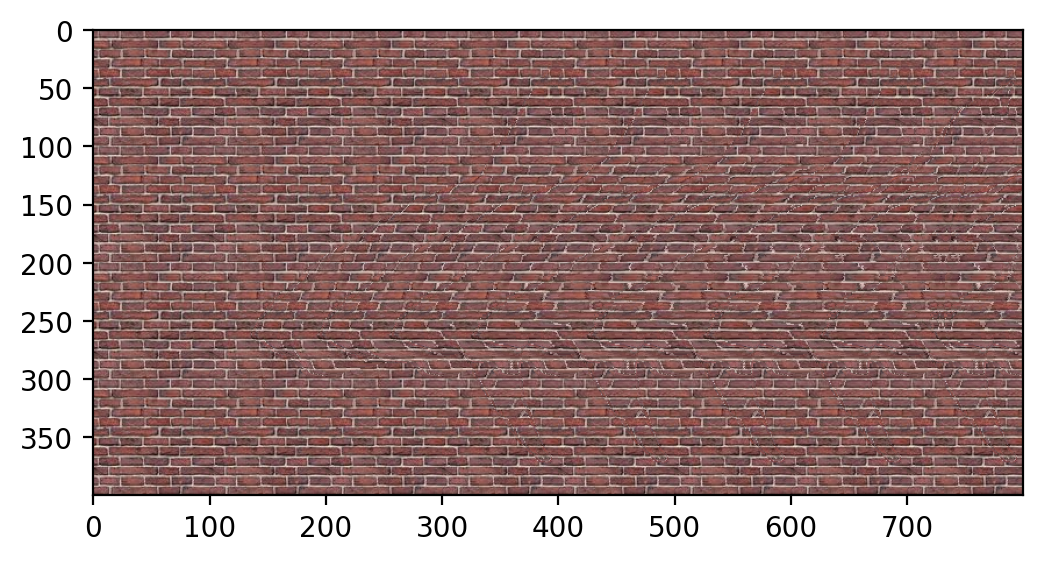

In [3]:
plt.rcParams['figure.dpi'] = 200

intensity = 0.6 # intensity of 3D depth (0.0-1.0)
depth_img = cv2.cvtColor(cv2.imread('images/shark_depth.png'), cv2.COLOR_BGR2GRAY).astype('double') / 255.0
tex_img = cv2.cvtColor(cv2.imread('images/bricks.jpg'), cv2.COLOR_BGR2RGB) / 255.0
patch_w = tex_img.shape[1]
out_size = (out_h, out_w) = (depth_img.shape[0], depth_img.shape[1]+patch_w)
out = np.zeros((*out_size,3)).astype('double')

for r, row in enumerate(out):
    # seed is now a row of the given texture
    seed = tex_img[r % tex_img.shape[0], 0:patch_w]
    row[0:patch_w] = seed
    # sample remaining pixels in row based on depth
    for c in range(0, depth_img.shape[1]):
        depth = depth_img[r,c]
        offset = round(depth*patch_w*intensity)
        out[r, c+patch_w] = out[r, c+offset]
out = out[:,patch_w:] # remove seed columns so image is centered

plt.imshow(out, cmap='gray', vmin=0, vmax=1)
plt.show()

### Extensions

In [4]:
# %matplotlib qt
# plt.rcParams['figure.dpi'] = 200
# plt.grid(b=None)
# # plt.ion()
# fig = plt.figure()


# depth_img = cv2.cvtColor(cv2.imread('shark_depth.png'), cv2.COLOR_BGR2GRAY).astype('double') / 255.0
# out_size = (out_h, out_w) = (depth_img.shape[0], depth_img.shape[1])


# for shift in range(-200, 200, 20):
#     # shift = -50
#     out = np.zeros(out_size).astype('double')
#     for r in range(out_h):
#         for c in range(out_w):
#             z = depth_img[r,c]
#             s = max(min(c+int(z*shift), out_w-1),0)
#             out[r,c] = depth_img[r,s]

#     plt.imshow(make_stereogram(out), cmap='gray', vmin=0, vmax=1)
#     fig.canvas.draw()
#     fig.canvas.flush_events()
#     plt.clf()

### Decoding Autostereograms

In [15]:
from tqdm import tqdm

In [16]:
def findOptimalWindow(img, minSplit=4, maxSplit=16):
    maxWin = int(img.shape[1] / minSplit)
    minWin = int(img.shape[1] / maxSplit)
    print("max window size:", maxWin, ", min window size: ", minWin)
    
    vals = []
    for i in range(minWin,maxWin):
        # compute difference of the sum of the first two columns defined by the window width.
        left = np.sum(img[:, :i])
        right = np.sum(img[:, i:2*i])
        # normalize for the window total area
        vals.append((np.abs(left - right) / (i * img.shape[0]), i))
    
    sorted_vals = sorted(vals)
    # finally take the minimum ssd value from the list and return its window size
    return sorted_vals[0][1]



In [17]:
# get depth map
def doMagicEye(img, window, samplesz):
    half_window = window // 2
    dmap = np.zeros((img.shape[0], img.shape[1]-window),dtype='int32')
    # really wish I could get rid of this iteration
    for vidx in tqdm(range(1,img.shape[0]-1)): # for each row
        for hidx in range(1,img.shape[1]-window-1): #for each pixel in the row
            # do ssd difference of current chunk and a test chunk for a bunch of test locations
            vals = []
            for offset in range(half_window, window - samplesz):
                ssd = ((img[vidx, hidx:hidx+samplesz] - img[vidx, hidx+offset:hidx+offset+samplesz])**2).sum()
                vals.append(ssd)
            best = np.where(np.array(vals) == np.min(vals))[0][-1]
            dmap[vidx][hidx] = best

    return dmap


(400, 800, 3)


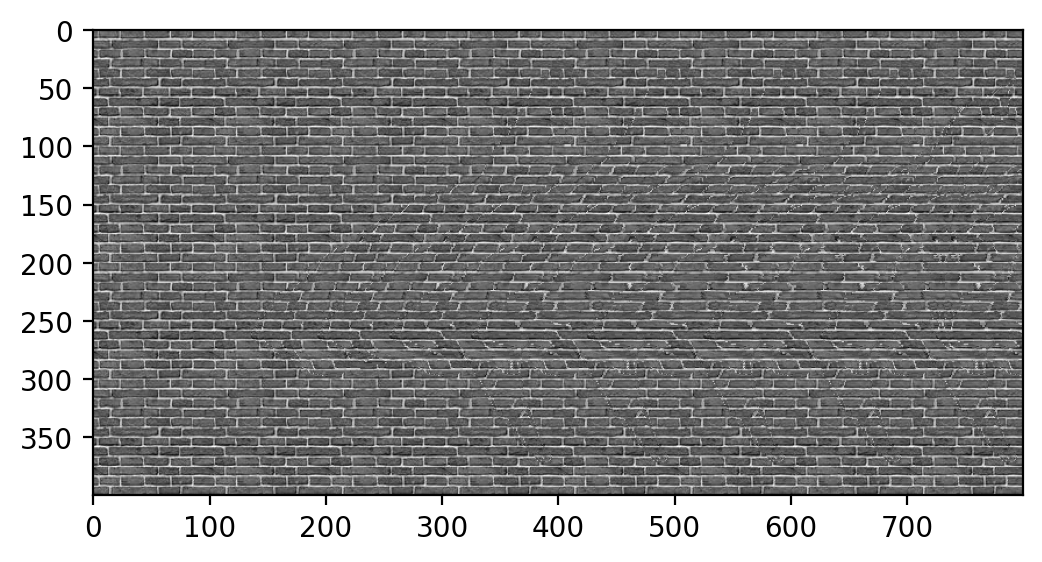

max window size: 200 , min window size:  50
1.0
image: 800x400
window: 180
sample: 18


100%|█████████████████████████████████████████| 398/398 [00:41<00:00,  9.65it/s]


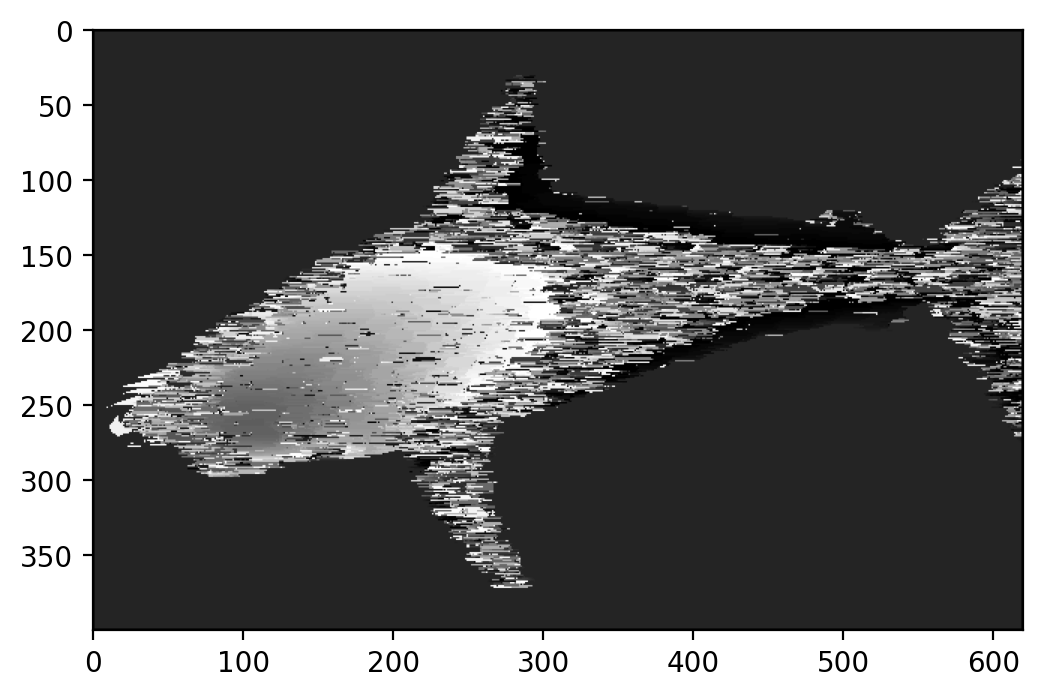

In [18]:
searchWndw = 1.0

# open image and create integral image
# img = cv2.cvtColor(out, cv2.COLOR_BGR2GRAY).astype('double') / 255.0
img = out
print(img.shape)
img = cv2.cvtColor(img.astype('float32'), cv2.COLOR_BGR2GRAY)
plt.imshow(img, cmap="gray")
plt.show()

# find our search window and make it big
window = int(searchWndw*findOptimalWindow(img))
print(searchWndw)
print("image: {0}x{1}".format(img.shape[1], img.shape[0]))
print("window: {0}".format(window))

# how big of a signal we match on 
samplesz = window // 10
print("sample: {0}".format(samplesz))
numProc = 4
dmap = doMagicEye(img, window, samplesz)

plt.imshow(dmap, cmap="gray")
plt.show()

<class 'numpy.ndarray'>
(400, 620)
<class 'numpy.uint8'>


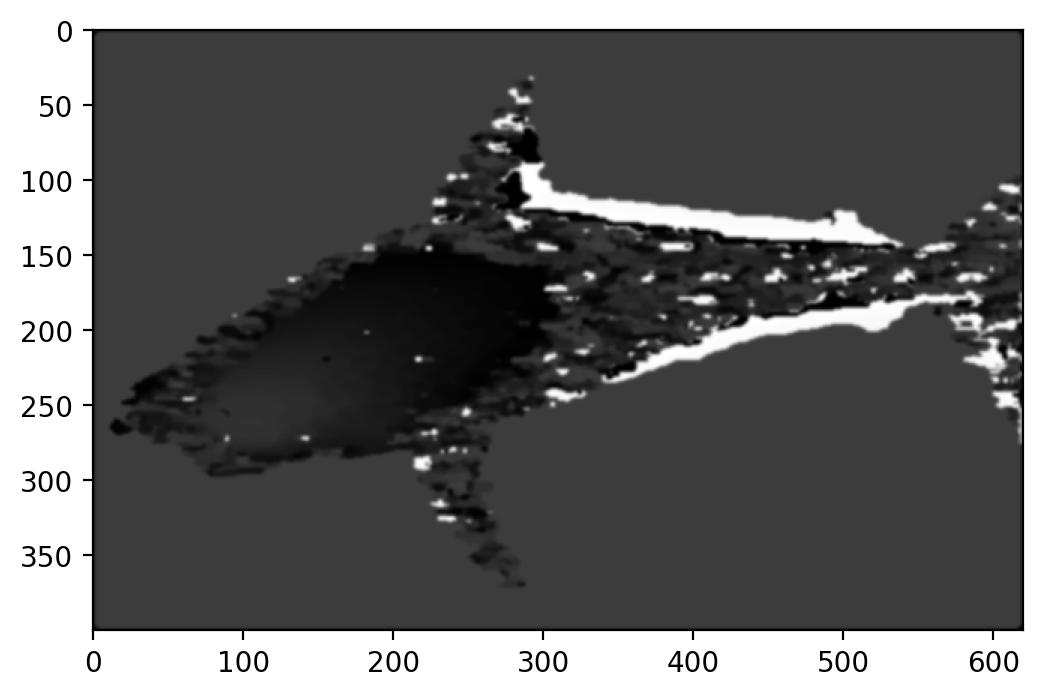

In [19]:
# create the cleaned up output
print(type(dmap))
print(dmap.shape)
dmap = dmap.astype('uint8')
print(type(dmap[0, 0]))
result = cv2.GaussianBlur(1 - cv2.cv2.equalizeHist(cv2.medianBlur(dmap, 5)), (5,5), 0) 
plt.imshow(result, cmap="gray")
plt.show()